# Apply drift correction to NorESM

In [2]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
#xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

import pickle

In [3]:
# load custom functions for analyzing flat10

from loading_function_flat10 import load_flat10, load_one_model, load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


In [4]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

################
##### Dask #####
################

def get_ClusterClient(
        ncores=1,
        nmem='200GB',
        walltime='01:00:00',
        account='UWAS0155'):
    """
    Code from Daniel Kennedy
    More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html
    """
    cluster = PBSCluster(
        cores=ncores,              # The number of cores you want
        memory=nmem,               # Amount of memory
        processes=ncores,          # How many processes
        queue='casper',            # Queue name
        resource_spec='select=1:ncpus=' +\
        str(ncores)+':mem='+nmem,  # Specify resources
        account=account,           # Input your project ID here
        walltime=walltime,         # Amount of wall time
        interface='ext',           # Interface to use
    )

    client = Client(cluster)
    return cluster, client

### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 
CNRM-ESM2-1  
HadCM3LC-Bris  
UKESM1.2  

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [5]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

# modellist_orig= ['ACCESS-ESM1-5',  
#             'CESM2',    
#             'GFDL-ESM4',  
#             'GISS_E2.1',  
#             'NorESM2-LM',
#             'MPI-ESM1-2-LR',
#             'CNRM-ESM2-1',
#             'HadCM3LC-Bris',
#             'UKESM1.2']
# modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

# varlist_load=['cVeg','cSoil','cLitter']#,'nbp','gpp','rh','tas','pr'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
# varlist_analyze=['cVeg','cSoil','cTot','cLitter']#,'nbp','gpp','rh','tas','pr']
# varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1','K','kg m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']

troplat=30
highlat=60

In [6]:
##------ only for NorESM

modellist=['NorESM2-LM']
#modellist=['UKESM1.2']
#runlist=['flat10_zec']
#runlist_wc = ['*zec']
varlist=['cSoil']#'cVeg']#,'cSoil','cLitter']

In [7]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [8]:
# initialize a dictionary to hold all of the data
data_dict={}

### Start Dask workers

In [9]:
# ## Create Dask cluster and client, scale up to 20 workers
# cluster, client = get_ClusterClient(walltime='01:00:00')
# cluster.scale(20)
# client.wait_for_workers(20)

# ## Lists active workers and their status
# cluster.workers

### Load grid info

In [10]:
data_dict = load_grid(data_dict,modellist)

NorESM2-LM getting grid info


### Load data

In [11]:
#runlist_wc = ['*lat10','*zec','*cdr']

#ds0=load_one_model_onevar(model,runlist_wc[0],var)
#ds1=load_one_model_onevar(model,runlist_wc[1],var)
#ds2=load_one_model_onevar(model,runlist_wc[2],var)

In [12]:
#data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

In [13]:
#modellist=modellist_orig
#varlist=varlist_analyze

# Calculate Metrics

### zonal average land sink

Zonal average land sink is calculated from total carbon on land averaged into latitude bands

In [14]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('processing model: ' +model)

    # get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']

    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('processing run: ' +run)

        # get data from the dictionary
        #ds=data_dict[modellist[m] +'_' +runlist[e]]
        
    
        
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('processing variable: ' +var)
            ds=load_one_model_onevar(modellist[m],runlist_wc[e],var)

            # calculate land area
            # adjust the area grid for CESM
            if model=='CESM2':
                area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
            else:
                area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
                landfrac=landfrac/100
                
            landarea=area*landfrac

            # make an annual time series that is properly weighted by days in month
            data_var= weighted_temporal_mean(ds, var) # this is probably memory intesive?

            # load the drift correction
            if model=='NorESM2-LM':
                if var=='cVeg':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=data_var['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850 # the start year for adjustment is 1850
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
                    
                    # ds[var]=ds[var]-adjustment # remove the drift from the variable
                    # data_var= data_var-adjustment
                
                elif var=='cSoil':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTSOMC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=data_var['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850 # the start year for adjustment is 1850
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    # data_var=data_var-adjustment # remove the drift from the variable
                    
                elif var=='cLitter':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTLITC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=data_var['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850 # the start year for adjustment is 1850
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    # data_var=data_var-adjustment # remove the drift from the variable

            
            #data_var= weighted_temporal_mean(ds, var) # this is probably memory intesive?

            if var=='tas' or var=='pr': 
                # if this is *not* a carbon variable then we want to make an average
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))/landarea.sum(dim=['lat','lon'])
                C_highlat=(((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon']))/((landarea.where(ds.lat>=highlat)).sum(dim=['lat','lon']))
                C_troplat=(((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))
                C_midlat=(((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))
    
                #put into matrix 
                C_global_mat[0:len(C_global),m,e,v]= C_global
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat
            
            else: # it is a carbon variable and we want to make a sum
                # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
                # our area variable is in m2
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
                C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
                C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
                C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
                #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
                C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg

            # reset values after the end of the time series to nan
            C_global_mat[(len(C_global)):,m,e,v]=np.nan
            C_highlat_mat[(len(C_highlat)):,m,e,v]=np.nan
            C_troplat_mat[(len(C_troplat)):,m,e,v]=np.nan
            C_midlat_mat[(len(C_midlat)):,m,e,v]=np.nan

            #del data_var
            del ds

## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

print('Done!')

processing model: NorESM2-LM
processing run: flat10
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *lat10 cSoil
processing run: flat10_zec
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *zec cSoil


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

processing run: flat10_cdr
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *cdr cSoil
Done!


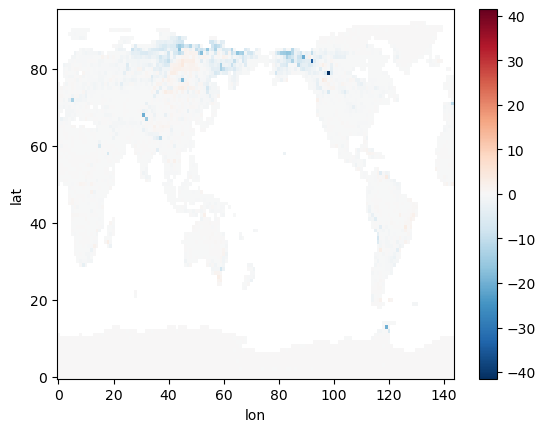

In [15]:
adj_matrix.plot()

In [16]:
ty=data_var['time'].dt.year
# tyindx=ty-ty[0]+1
tyindx=ty-1850+1
adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
                   

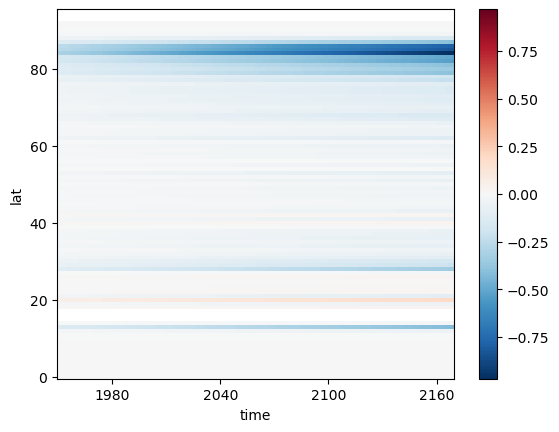

In [17]:
adjustment.mean(dim='lon').plot()

In [18]:
data_var['time'].dt.year

<xarray.DataArray 'year' (time: 220)> Size: 2kB
array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048,
       2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103,
       2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114,
       2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125,
       2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136,
       2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147,
       2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158,
       2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169])
Coordinates:
  * time     (time) object 2kB 1950-01-01 00:00:00 ... 2169-01-01 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [19]:
tyindx

<xarray.DataArray 'year' (time: 220)> Size: 2kB
array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
       283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
       296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
       309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320])
Coordinates:
  * time     (time) object 2kB 1950-01-01 00:00:00 ... 2169-01-01 00:00:00

In [20]:
np.shape(C_global_mat)

(350, 1, 3, 1)

In [21]:
C_global_mat[0:100,0,0,0]

array([2549.1150412 , 2549.05224925, 2549.04080522, 2549.0188147 ,
       2548.98039912, 2548.89384056, 2548.94412874, 2549.05940841,
       2549.10947593, 2549.27262903, 2549.48966748, 2549.64041558,
       2549.7763763 , 2550.06823124, 2550.19724687, 2550.31158341,
       2550.56227201, 2550.82402855, 2551.12596074, 2551.40110203,
       2551.69170378, 2551.90888025, 2552.20478835, 2552.5502526 ,
       2552.89891053, 2553.19636451, 2553.44926737, 2553.77201321,
       2554.11148214, 2554.54877634, 2554.92499825, 2555.29894507,
       2555.71442574, 2556.05594943, 2556.35658324, 2556.79937277,
       2557.29401836, 2557.75993863, 2558.1408033 , 2558.54000894,
       2559.02040994, 2559.50226099, 2559.91194081, 2560.21909333,
       2560.52482001, 2561.0455176 , 2561.45500276, 2561.86575028,
       2562.23301604, 2562.74234968, 2563.30914026, 2563.83608656,
       2564.36195195, 2564.80444592, 2565.23115152, 2565.78451921,
       2566.34761509, 2566.88478566, 2567.37998973, 2567.95031

In [22]:
C_global_mat[0:100,0,0,0]

array([2549.1150412 , 2549.05224925, 2549.04080522, 2549.0188147 ,
       2548.98039912, 2548.89384056, 2548.94412874, 2549.05940841,
       2549.10947593, 2549.27262903, 2549.48966748, 2549.64041558,
       2549.7763763 , 2550.06823124, 2550.19724687, 2550.31158341,
       2550.56227201, 2550.82402855, 2551.12596074, 2551.40110203,
       2551.69170378, 2551.90888025, 2552.20478835, 2552.5502526 ,
       2552.89891053, 2553.19636451, 2553.44926737, 2553.77201321,
       2554.11148214, 2554.54877634, 2554.92499825, 2555.29894507,
       2555.71442574, 2556.05594943, 2556.35658324, 2556.79937277,
       2557.29401836, 2557.75993863, 2558.1408033 , 2558.54000894,
       2559.02040994, 2559.50226099, 2559.91194081, 2560.21909333,
       2560.52482001, 2561.0455176 , 2561.45500276, 2561.86575028,
       2562.23301604, 2562.74234968, 2563.30914026, 2563.83608656,
       2564.36195195, 2564.80444592, 2565.23115152, 2565.78451921,
       2566.34761509, 2566.88478566, 2567.37998973, 2567.95031

In [23]:
C_global_mat[0:199,0,1,0]

array([2589.04248833, 2589.34965757, 2589.81058937, 2590.36913284,
       2590.88600679, 2591.45000696, 2592.15281278, 2592.74852261,
       2593.21518093, 2593.68878616, 2594.07023287, 2594.43056374,
       2594.85286037, 2595.32111981, 2595.72925059, 2595.99766637,
       2596.3933582 , 2596.81564255, 2597.19324302, 2597.62147074,
       2598.08999375, 2598.31787727, 2598.56775427, 2598.91154245,
       2599.26202381, 2599.51136534, 2599.79412863, 2600.14576825,
       2600.6585507 , 2601.10232439, 2601.52330146, 2601.90946398,
       2602.24780627, 2602.44277353, 2602.73243444, 2602.99456326,
       2603.20913619, 2603.5521109 , 2603.87717631, 2604.15210389,
       2604.49045885, 2604.84580624, 2605.19513766, 2605.45272201,
       2605.64382991, 2606.00749889, 2606.40060951, 2606.7510729 ,
       2606.99592936, 2607.16071675, 2607.3559443 , 2607.43339965,
       2607.61778693, 2607.85607048, 2608.18087467, 2608.38341798,
       2608.50367463, 2608.70138081, 2608.8786134 , 2609.07625

In [24]:
C_global_mat[0:199,0,2,0]

array([2589.08967643, 2589.52803816, 2590.04882706, 2590.54834317,
       2591.00510247, 2591.52557937, 2592.08905095, 2592.56265951,
       2593.07063691, 2593.55667824, 2593.86139095, 2594.29038138,
       2594.84015207, 2595.3135122 , 2595.80705504, 2596.23630522,
       2596.731094  , 2597.29747793, 2597.71589744, 2598.16143883,
       2598.61883458, 2599.17313645, 2599.47189967, 2599.74446726,
       2600.12942515, 2600.53987205, 2600.99162741, 2601.37080975,
       2601.70463131, 2602.18562165, 2602.60939473, 2603.1272664 ,
       2603.50240006, 2603.793743  , 2604.18504591, 2604.69829006,
       2605.29725434, 2605.79480867, 2606.17059894, 2606.40793344,
       2606.83478565, 2607.25617733, 2607.56165226, 2607.83246543,
       2608.31109547, 2608.63285452, 2608.96560433, 2609.36229735,
       2609.74712486, 2609.9559814 , 2610.28923356, 2610.79828063,
       2611.44292665, 2611.73591828, 2611.9923619 , 2612.32996381,
       2612.60781341, 2612.91686788, 2613.1658474 , 2613.50747

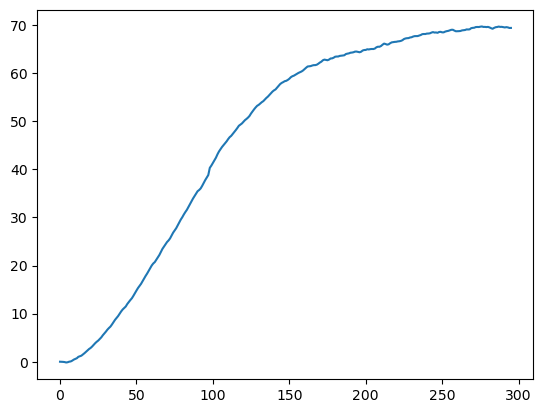

In [26]:
#timeseries=C_global_mat[0:199,0,2,0]

e=0
timeseriesE=C_global_mat[:,0,0,0]
# C_global_mat.sel(model=model, run=runlist[e], 
                               # var=varlist[v], latrange=latlist[0])
initC=np.mean(timeseriesE.data[1:10])

e=1
timeseries=C_global_mat[:,0,1,0]
# C_global_mat.sel(model=model, run=runlist[e], 
#                                var=varlist[v], latrange=latlist[0])

Cts=np.append(timeseriesE.data[1:99], timeseries.data[1:199]) - initC

plt.plot(Cts)

In [39]:
ds=load_one_model_onevar(model,'*lat10','cSoil')

loading variable: cSoil
finished loading NorESM2-LM *lat10 cSoil


In [43]:
arg=ds.time.dt.year - 1850

arg

<xarray.DataArray 'year' (time: 1799)> Size: 14kB
array([  0,   0,   0, ..., 149, 149, 149])
Coordinates:
  * time     (time) object 14kB 1850-02-15 00:00:00 ... 1999-12-16 12:00:00

In [15]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('processing model: ' +model)

    # get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']

    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('processing run: ' +run)

        # get data from the dictionary
        #ds=data_dict[modellist[m] +'_' +runlist[e]]
        
    
        
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            print('processing variable: ' +var)
            ds=load_one_model_onevar(modellist[m],runlist_wc[e],var)

            # calculate land area
            # adjust the area grid for CESM
            if model=='CESM2':
                area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
            else:
                area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
            
            if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
                landfrac=landfrac/100
                
            landarea=area*landfrac

            # load the drift correction
            if model=='NorESM2-LM':
                if var=='cVeg':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1
                    # # remove the first part for zec and cdr
                    # if run=='*zec': #zec experiment
                    #     adjustment = adjustment[:,:,150:] #[lat,lon,time]
                    # elif run=='*cdr': #cdr experiment

                    # else: # run == '*lat10'
                        
                    ds[var]=ds[var]-adjustment # remove the drift from the variable
                    
                elif var=='cSoil':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTSOMC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]-adjustment # remove the drift from the variable
                    
                elif var=='cLitter':
                    field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTLITC_ann_drift.pkl','rb'))
                    adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
                    ty=ds['time'].dt.year
                    # tyindx=ty-ty[0]+1
                    tyindx=ty-1850+1
                    adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

                    ds[var]=ds[var]-adjustment # remove the drift from the variable

            
            data_var= weighted_temporal_mean(ds, var) # this is probably memory intesive?

            if var=='tas' or var=='pr': 
                # if this is *not* a carbon variable then we want to make an average
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))/landarea.sum(dim=['lat','lon'])
                C_highlat=(((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon']))/((landarea.where(ds.lat>=highlat)).sum(dim=['lat','lon']))
                C_troplat=(((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon']))
                C_midlat=(((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))/((landarea.where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon']))
    
                #put into matrix 
                C_global_mat[0:len(C_global),m,e,v]= C_global
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat
            
            else: # it is a carbon variable and we want to make a sum
                # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
                # our area variable is in m2
                C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
                C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
                C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
                C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
                #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
                C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
                C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
                C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
                C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg

            # reset values after the end of the time series to nan
            C_global_mat[(len(C_global)):,m,e,v]=np.nan
            C_highlat_mat[(len(C_highlat)):,m,e,v]=np.nan
            C_troplat_mat[(len(C_troplat)):,m,e,v]=np.nan
            C_midlat_mat[(len(C_midlat)):,m,e,v]=np.nan

            del data_var
            del ds

## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

processing model: NorESM2-LM
processing run: flat10
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *lat10 cSoil


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

processing run: flat10_zec
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *zec cSoil


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

processing run: flat10_cdr
processing variable: cSoil
loading variable: cSoil
finished loading NorESM2-LM *cdr cSoil


/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/glade/u/apps/opt/conda/envs/npl-2025b/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid

In [17]:
C_global_mat[0:99,0,0,0]

array([2549.05396417, 2548.9300952 , 2548.85757414, 2548.77450659,
       2548.67501399, 2548.52737841, 2548.51658956, 2548.57079221,
       2548.5597827 , 2548.66185878, 2548.81782021, 2548.90749128,
       2548.98237497, 2549.21315288, 2549.28109149, 2549.33435101,
       2549.52396258, 2549.72464209, 2549.96549726, 2550.17956153,
       2550.40908625, 2550.5651857 , 2550.80001677, 2551.08440399,
       2551.3719849 , 2551.60836185, 2551.80018769, 2552.0618565 ,
       2552.34024841, 2552.71646558, 2553.03161047, 2553.34448026,
       2553.69888391, 2553.97933057, 2554.21888735, 2554.60059986,
       2555.03416843, 2555.43901167, 2555.75879932, 2556.09692793,
       2556.51625191, 2556.93702593, 2557.28562872, 2557.53170422,
       2557.77635388, 2558.23597444, 2558.58438257, 2558.93405307,
       2559.24024181, 2559.68849841, 2560.19421197, 2560.66008125,
       2561.12486961, 2561.50628655, 2561.87191513, 2562.36420579,
       2562.86622466, 2563.3423182 , 2563.77644525, 2564.28569

In [18]:
C_global_mat[0:199,0,1,0]

array([2587.30976256, 2587.58993692, 2587.95115652, 2588.35833893,
       2588.70539269, 2588.91273144, 2589.24734625, 2589.60855358,
       2589.92507702, 2590.29222771, 2590.6996737 , 2590.86648019,
       2591.05528017, 2591.33799132, 2591.62739566, 2591.81566017,
       2592.03734642, 2592.32790902, 2592.77961445, 2593.16231111,
       2593.52221115, 2593.84729665, 2594.12456192, 2594.25845215,
       2594.48703604, 2594.68808783, 2594.84158374, 2595.12348142,
       2595.3874698 , 2595.60132036, 2595.87859829, 2596.17286866,
       2596.46112305, 2596.65763038, 2596.78766125, 2597.0902532 ,
       2597.42228681, 2597.71167317, 2597.8954526 , 2597.99916296,
       2598.13331349, 2598.14969182, 2598.27300207, 2598.4502086 ,
       2598.71393576, 2598.85540204, 2598.91458167, 2599.05121082,
       2599.16736639, 2599.30393102, 2599.39724993, 2599.47625559,
       2599.62966974, 2599.86179235, 2600.07847138, 2600.27352647,
       2600.25258776, 2600.23251086, 2600.29234105, 2600.30944

In [14]:
# put the matrix into an xarray dataset
latlist=['global','highlat','troplat','midlat']

data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat

In [15]:
np.shape(data_array_combined)

(350, 1, 1, 1, 4)

In [7]:
ds

NameError: name 'ds' is not defined

In [16]:
data_var

<xarray.DataArray (time: 210, lat: 96, lon: 144)> Size: 23MB
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    latitude   (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
    longitude  (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2kB 1960-01-01 00:00:00 ... 2169-01-01 00:00:00

In [17]:
arg=C_global_mat[:,m,e,v]

arg

array([2594.02823533, 2594.30840969, 2594.66962929, 2595.0768117 ,
       2595.42386547, 2595.63120422, 2595.96581903, 2596.32702635,
       2596.64354979, 2597.01070049, 2597.41814648, 2597.58495297,
       2597.77375294, 2598.05646409, 2598.34586843, 2598.53413294,
       2598.7558192 , 2599.04638179, 2599.49808722, 2599.88078389,
       2600.24068393, 2600.56576942, 2600.84303469, 2600.97692492,
       2601.20550881, 2601.4065606 , 2601.56005651, 2601.84195419,
       2602.10594257, 2602.31979314, 2602.59707107, 2602.89134143,
       2603.17959583, 2603.37610315, 2603.50613403, 2603.80872598,
       2604.14075958, 2604.43014594, 2604.61392538, 2604.71763574,
       2604.85178626, 2604.86816459, 2604.99147485, 2605.16868137,
       2605.43240853, 2605.57387482, 2605.63305445, 2605.7696836 ,
       2605.88583917, 2606.0224038 , 2606.11572271, 2606.19472836,
       2606.34814252, 2606.58026512, 2606.79694416, 2606.99199924,
       2606.97106053, 2606.95098363, 2607.01081382, 2607.02791

In [18]:


ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)

In [19]:
ds_C_global

<xarray.Dataset> Size: 14kB
Dimensions:   (time: 350, model: 1, run: 1, var: 1, latrange: 4)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
  * model     (model) <U10 40B 'NorESM2-LM'
  * run       (run) <U10 40B 'flat10_zec'
  * var       (var) <U5 20B 'cSoil'
  * latrange  (latrange) <U7 112B 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 11kB 2.594e+03 ... nan

In [20]:
# - save the matrix to a netcdf file

##ds_C_global.to_netcdf("C_metrics_matrix.nc")

<xarray.Dataset> Size: 6kB
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 3kB 0 1 2 3 4 5 6 7 ... 343 344 345 346 347 348 349
    model     <U10 40B 'NorESM2-LM'
    run       <U10 40B 'flat10_zec'
    var       <U5 20B 'cSoil'
    latrange  <U7 28B 'global'
Data variables:
    data      (time) float64 3kB 2.594e+03 2.594e+03 2.595e+03 ... nan nan nan


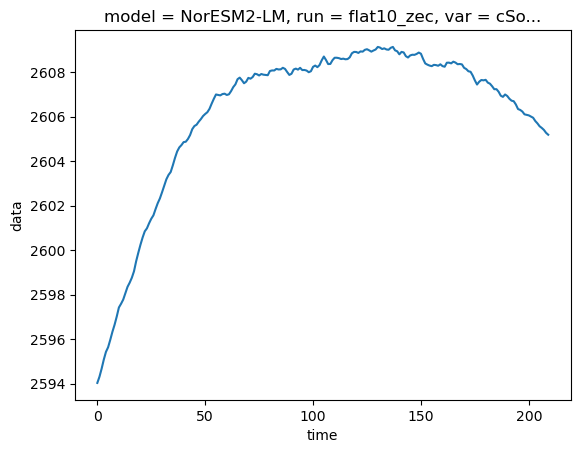

In [21]:
# to load data from this ds

# Access data for one model, run, var, latrange

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var=varlist[0], latrange='global')

print(subset)

subset.data.plot()

## Shut down dask

In [22]:
## Once done, shut down the cluster
# client.shutdown()

In [23]:
# # clean up
# !rm ./dask-worker.e*
# !rm ./dask-worker.o*

# #---------# Snippets below #-----------#

(96, 144, 1799)


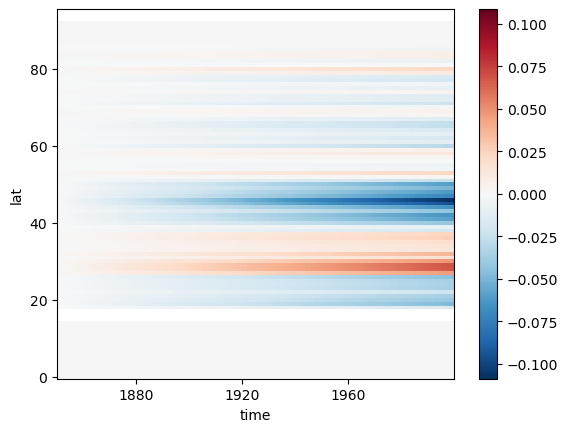

In [33]:
model='NorESM2-LM'
var='cVeg'
field = pickle.load(open('/glade/campaign/cgd/tss/people/aswann/flat10/NorESM2-LM/NorESM2-LM_2D_TOTVEGC_ann_drift.pkl','rb'))
adj_matrix = xr.DataArray(np.squeeze(field), dims=['lat','lon'], coords={'latitude': ds.lat, 'longitude':ds.lon})##,unit={'g C m-2 yr-1'})
ty=ds['time'].dt.year
tyindx=ty-1850+1
adjustment = adj_matrix* tyindx*(1/1000) #this is the drift for each time point and each gridcell in kg C m-2 yr-1

print(np.shape(adjustment))

adjustment.mean(dim='lon').plot()

In [34]:
ty

<xarray.DataArray 'year' (time: 1799)> Size: 14kB
array([1850, 1850, 1850, ..., 1999, 1999, 1999])
Coordinates:
  * time     (time) object 14kB 1850-02-15 00:00:00 ... 1999-12-16 12:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [19]:
np.shape(field)

(1, 96, 144)